In [1]:
import copy
import itertools
from pprint import pprint
import warnings



import numpy as np
import luigi
import dill
import pandas as pd

from experiment_framework.helpers import load_completed_CCCs_into_dataframe, load_completed_AAs_into_dataframe
from empirical_privacy.row_distributed_svd import \
svd_dataset_settings, ExpCCCSVD, CCCSVD, AllSVDAsymptotics
from dataset_utils.recsys_datasets import get_ml1m_user
from dataset_utils.text_datasets import get_twenty_doc

from notebook_context import *

# Measuring and analyzing asymptotic accuracy

##### Experiment 2 -- distributed SVD on two datasets

This experiment should complete overnight on a 2012+ 4-8 core machine.

In [2]:
warnings.simplefilter('ignore')  # luigi's warnings are not relevant to use
asymptotics_job = AllSVDAsymptotics(datasets=['ml-1m', '20NG'],
                                    part_fractions=[0.01])

##### Experiment 3 -- distributed SVD with larger part fractions

In [3]:
# uncomment the experiment you want to run and re-run the cells below

# this takes a couple days on a 16-core machine
asymptotics_job = AllSVDAsymptotics(datasets=['ml-1m', '20NG'],
                                    part_fractions=[0.01, 0.1])

# this takes over a week on a 16-core machine
# asymptotics_job = AllSVDAsymptotics(datasets=['ml-1m', '20NG'],
#                                     part_fractions=[0.01, 0.1, 0.9])

### Run the Experiment and Visualize Results

In [4]:
AAs = asymptotics_job.requires()
luigi.build(AAs, local_scheduler=True, workers=4, log_level='ERROR')
DF = load_completed_AAs_into_dataframe(AAs)
DF.to_csv('AsymptoticsResults.csv')

In [5]:
DF_asymptotics = pd.read_csv('AsymptoticsResults.csv')
CCCs = [AA.requires()['CCC'] for AA in AAs]
DF_ccc = load_completed_CCCs_into_dataframe(CCCs)

In [6]:
n_docs = DF_asymptotics.doc_ind.nunique()
n_max = DF_ccc.n_max.max()
print(n_docs)
DF_asymptotics = DF_asymptotics[
    DF_asymptotics.n_trials_per_training_set_size 
    == DF_asymptotics.n_trials_per_training_set_size.max()]

print(DF_asymptotics.columns)
print(DF_ccc.columns)
intersection_index = DF_asymptotics.columns.intersection(DF_ccc.columns)
print('Intersection = ', intersection_index)

DF = DF_ccc.merge(DF_asymptotics,
                  on=intersection_index.values.tolist(),
                  how='outer')
DF.loc[DF.classifier_accuracy < 0.5, 'classifier_accuracy'] = 0.5

5
Index(['Unnamed: 0', 'SVD_k', 'SVD_type', 'confidence_interval_prob',
       'confidence_interval_width', 'dataset_name', 'doc_ind', 'k_chebyshev',
       'mean', 'median', 'n_bootstraps', 'n_max',
       'n_trials_per_training_set_size', 'p', 'part_fraction', 'std',
       'upper_bound', 'validation_set_size'],
      dtype='object')
Index(['SVD_k', 'SVD_type', 'classifier_accuracy', 'dataset_name', 'doc_ind',
       'n_max', 'n_trials_per_training_set_size', 'part_fraction',
       'training_set_size', 'trial', 'validation_set_size'],
      dtype='object')
Intersection =  Index(['SVD_k', 'SVD_type', 'dataset_name', 'doc_ind', 'n_max',
       'n_trials_per_training_set_size', 'part_fraction',
       'validation_set_size'],
      dtype='object')


### Plot the results

In [7]:
configure_plotting_for_publication()

def query_df(DF, subview):
    query = ' & '.join(['{k}=={v}'.format(k=k, v=v if type(v) is not str else '"'+v+'"') for k,v in subview.items()])
    return DF.query(query)

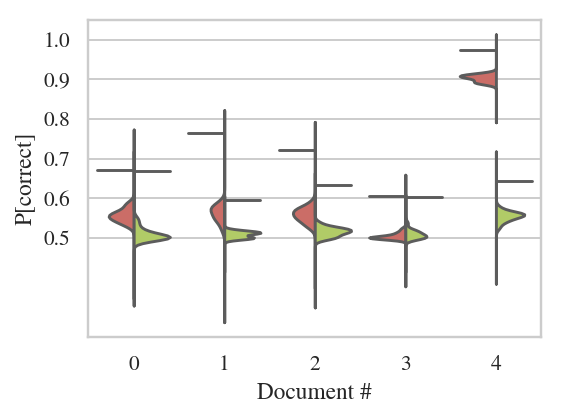

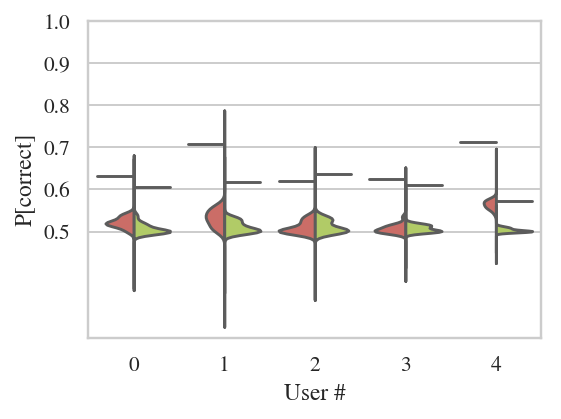

In [10]:
# SDF = DF[DF.training_set_size==n_max]
group_by = ['dataset_name']
cp = sns.color_palette('hls', n_docs)
for gn, sub_df in DF.groupby(group_by):
    sub_df = sub_df[sub_df.training_set_size==n_max]
    plt.figure()
    ax = sns.violinplot(
                        x='doc_ind',
                        y='classifier_accuracy', 
                        hue="part_fraction",
                        inner=None,
                        cut=20,
                        data=sub_df,
                        split=True,  # split the violin
                        palette=cp,
                        scale='area'
            )
    ax = sns.violinplot(
                        x='doc_ind',
                        y='upper_bound', 
                        hue="part_fraction",
                        data=sub_df,
                        inner=None,
                        split=True,  # split the violin
                        palette=cp,)
    handles, _ = ax.get_legend_handles_labels()
    plt.ylabel('P[correct]')
    if gn=='20NG':
        plt.xlabel('Document #')
    if gn=='ml-1m':
        plt.xlabel('User #')
    plt.legend(handles,
               DF.part_fraction.unique(),
               ncol=3,
               loc=(0, 1.05))
    plt.yticks(np.arange(0.5,1.01,0.1))
    if SAVE_FIGURES_FOR_LATEX:
        export_legend(ax.get_legend(),
                     filename=join(FIGURES_PATH, 'experiment2_legend.eps'))
        plt.tight_layout()
        plt.savefig(join(FIGURES_PATH, 'experiment2_{}.eps'.format(gn)))


### Experiment 4 -- effect of hiding eigenvalues

In [12]:
import itertools
asymptotics_jobs = [AllSVDAsymptotics(datasets=['ml-1m', '20NG'],
                                      part_fractions=[0.01],
                                      svd_kwargs={'SVD_type':k})
                    for k in ['hidden_eigs',
                              'exposed_eigs',
#                               'full_correlation'
                             ]
                   ]
AAs = list(itertools.chain(*[aj.requires() for aj in asymptotics_jobs]))
luigi.build(AAs, local_scheduler=True, workers=4, log_level='ERROR')

True